<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span><ul class="toc-item"><li><span><a href="#Not-through-papermill" data-toc-modified-id="Not-through-papermill-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Not through papermill</a></span></li></ul></li><li><span><a href="#Load-Cell-Metadata" data-toc-modified-id="Load-Cell-Metadata-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load Cell Metadata</a></span></li><li><span><a href="#Basic-metrics-distribution" data-toc-modified-id="Basic-metrics-distribution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Basic metrics distribution</a></span></li><li><span><a href="#Filter-by-basic-QC-metrics" data-toc-modified-id="Filter-by-basic-QC-metrics-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Filter by basic QC metrics</a></span></li><li><span><a href="#Other-Stats" data-toc-modified-id="Other-Stats-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Other Stats</a></span></li><li><span><a href="#Plateview-of-key-metrics" data-toc-modified-id="Plateview-of-key-metrics-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plateview of key metrics</a></span></li></ul></div>

# Basic Data Walkthrough and Cell Mapping Metric Filtering

## Purpose
- Overview of basic QC metrics per brain region
- Have a simple cell filtering based on basic QC metrics

## Input
- Cell metadata table

## Output
- Selected cell metadata table

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from cemba_data.plot.preprocessing import cutoff_vs_cell_remain, plot_on_plate

In [3]:
result_dir = pathlib.Path()
fig_dir = result_dir / 'fig/cell_basic_qc'
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
study_name = ''

cell_metadata_path = ''

In [5]:
# Parameters
study_name = "CLA"
cell_metadata_path = "/home/hanliu/project/mouse_rostral_brain/study/Level3-SubCellType/CLA/CellMetadata.msg"


### Not through papermill

In [6]:
# QC metric filtering
qc_metric = {
    'CCC_Rate': (0, 0.05),
    'CG_RateAdj': (0.5, 1),
    'CH_RateAdj': (0., 0.15),
    'FinalReads': (500000, 10000000),
    'MappingRate': (0.5, 1)
}

# plot cell metadata columns
metadata_distribution_plot = {
    'CCC_Rate': (0., 0.1),
    'CH_RateAdj': (0, 0.1),
    'CG_RateAdj': (0.7, 0.9),
    'InputReads': (0, 1e7),
    'MappedReads': (0, 1e7),
    'FinalReads': (0, 1e7),
    'MappingRate': (0.5, 1)
}

final_reads_column = 'FinalReads'
plate_view = False

## Load Cell Metadata

In [7]:
total_cell_meta = pd.read_msgpack(cell_metadata_path)

In [8]:
cell_metadata_include = {}
cell_metadata_exclude = {}

# apply cell metadata and cell list selection first
judges = []
for k, v in cell_metadata_include.items():
    judges.append(total_cell_meta[k].isin(v))
for k, v in cell_metadata_exclude.items():
    judges.append(~total_cell_meta[k].isin(v))

if len(judges) != 0:
    cell_meta = total_cell_meta[np.all(judges, axis=0)].copy()
else:
    cell_meta = total_cell_meta

## Basic metrics distribution

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


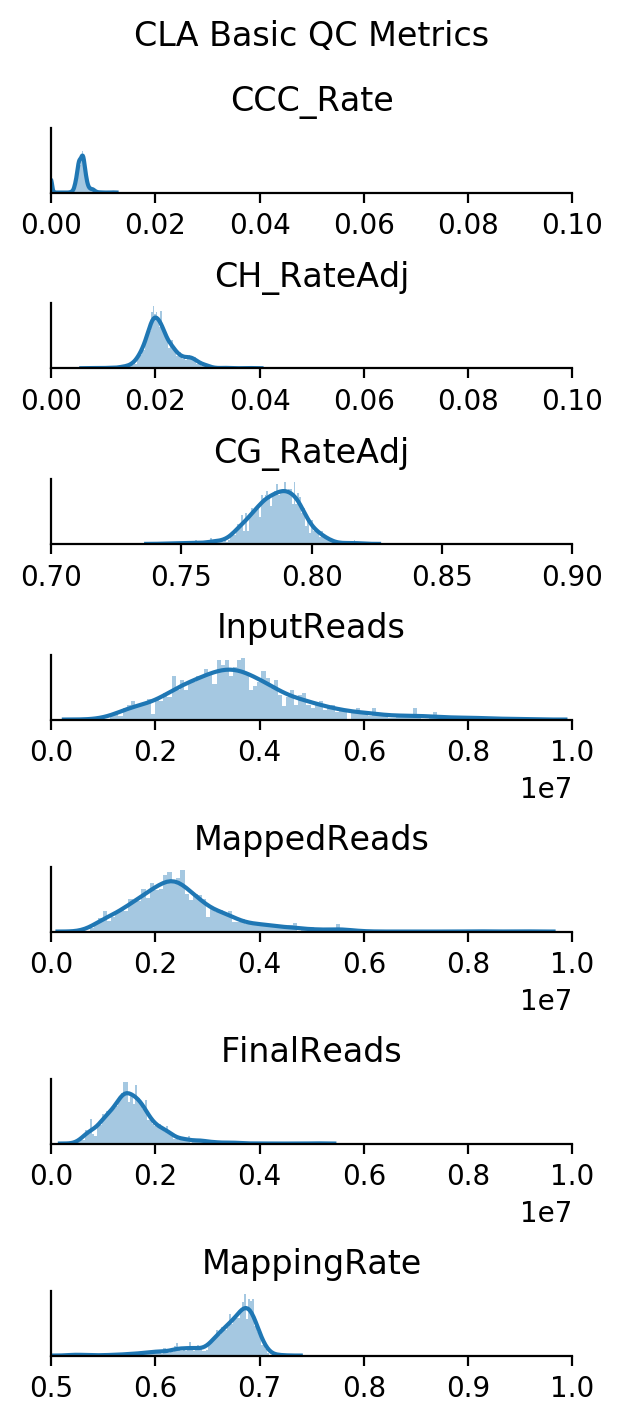

In [9]:
nrows = len(metadata_distribution_plot)
if nrows != 0:
    fig, axes = plt.subplots(nrows=nrows,
                             constrained_layout=True,
                             figsize=(3, nrows),
                             dpi=200)
    for (col, xlim), ax in zip(metadata_distribution_plot.items(), axes.flat):
        _data = cell_meta[col]
        _data = _data[(_data <= xlim[1]) & (_data >= xlim[0])]
        sns.distplot(_data, ax=ax, bins=100)
        ax.set(xlim=xlim, yticks=[], xlabel='', title=col)
    sns.despine(fig=fig, trim=True)

    fig.suptitle(f'{study_name} Basic QC Metrics')

    fig.savefig(fig_dir / f'basic_qc_metric.pdf')

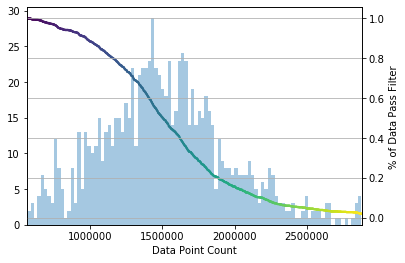

In [10]:
try:
    fig, axes = cutoff_vs_cell_remain(cell_meta[final_reads_column],
                                      xlim_quantile=(0.001, 0.98))
    fig.savefig(fig_dir / 'FinalReads distribution')
except KeyError:
    print(f'{final_reads_column} not in cell_meta, skip')

## Filter by basic QC metrics

In [11]:
judges = []
for col, (vmin, vmax) in qc_metric.items():
    judge = (cell_meta[col] >= vmin) & (cell_meta[col] <= vmax)
    print(
        f'{col} passed {judge.sum()}/{judge.size} ({(100*judge.sum()/judge.size):.1f}%)'
    )
    judges.append(judge)
cell_meta['PassFilter'] = np.all(judges, axis=0)

total_number = cell_meta['PassFilter'].sum()
print(
    f'Overall passed {total_number}/{judge.size} ({(100*total_number/cell_meta.shape[0]):.1f}%)'
)

CCC_Rate passed 945/945 (100.0%)
CG_RateAdj passed 945/945 (100.0%)
CH_RateAdj passed 945/945 (100.0%)
FinalReads passed 945/945 (100.0%)
MappingRate passed 945/945 (100.0%)
Overall passed 945/945 (100.0%)


In [12]:
cell_meta.to_msgpack('CellMetadata.AfterQC.msg')

## Other Stats

In [13]:
print('Cells pass basic QC in each batch:')
for k, v in cell_meta.groupby('FACS_Date')['PassFilter'].sum().astype(
        int).items():
    print(k, v)

Cells pass basic QC in each batch:
171206 7
171207 14
171214 13
171219 15
180109 11
180110 1
180119 4
180213 4
180220 2
180222 5
180227 2
180305 1
180306 3
180313 7
180319 8
180320 49
180326 44
180329 37
180402 30
180403 31
180405 16
180409 4
180410 7
180412 62
180416 93
180417 10
180419 25
180423 2
180424 1
180430 4
180529 4
180925 1
181002 41
181008 35
181009 54
181022 1
181023 1
181206 15
181210 32
181218 11
181220 6
190122 44
190124 35
190131 75
190205 77
190212 1


In [14]:
print('Cells pass basic QC in each random index:')
for k, v in cell_meta.groupby('index_name')['PassFilter'].sum().astype(
        int).items():
    print(k, v, f'{v/3.84:.1f}%')

Cells pass basic QC in each random index:
ad001 106 27.6%
ad002 127 33.1%
ad004 122 31.8%
ad006 104 27.1%
ad007 133 34.6%
ad008 116 30.2%
ad010 123 32.0%
ad012 114 29.7%


## Plateview of key metrics

In [15]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'FinalReads',
                              'Plate',
                              vmin=5e5,
                              vmax=3e6,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.FinalReads.pdf')

In [16]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CG_RateAdj',
                              'Plate',
                              vmin=0.65,
                              vmax=0.85,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CG_RateAdj.pdf')

In [17]:
if plate_view:
    fig, axes = plot_on_plate(cell_meta,
                              'CH_RateAdj',
                              'Plate',
                              vmin=0,
                              vmax=0.05,
                              heatmap_kws={
                                  'linewidth': 0,
                                  'linecolor': '#EEEEEE'
                              },
                              aggregation_func=lambda i: i.mean())
    fig.savefig(fig_dir / f'384plate.CH_RateAdj.pdf')

In [18]:
cell_meta

,AllcPath,CCC_Rate,CG_Rate,CG_RateAdj,CH_Rate,CH_RateAdj,FinalReads,InputReads,MappedReads,Region,...,l1-umap_0,l1-umap_1,l1-tsne_0,l1-tsne_1,MajorType,l2-umap_0,l2-umap_1,l2-tsne_0,l2-tsne_1,PassFilter
cell,,,,,,,,,,,,,,,,,,,,,
1A_M_1995,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.004440,0.778200,0.777210,0.021630,0.017270,2862583.0,6781502,4625469.0,1A,...,-0.300015,-27.730551,-48.198623,0.059535,CLA,13.118811,-0.083861,62.153488,-4.265882,True
1A_M_2395,/gale/raidix/rdx-4/CEMBA_RS1/1A/CEMBA180227_1A...,0.005410,0.789120,0.787970,0.028600,0.023320,726212.0,1389778,937940.0,1A,...,-0.487782,-26.794920,-48.693019,2.494923,CLA,12.229153,0.467961,58.775268,-8.430705,True
1B_M_1327,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006350,0.773220,0.771770,0.024100,0.017860,1202888.0,2715614,1738735.0,1B,...,-0.152041,-27.566145,-48.914656,0.722261,CLA,13.115620,0.316232,61.838474,-5.296292,True
1B_M_1545,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180213_1B...,0.006500,0.780580,0.779140,0.023970,0.017580,1339041.0,2890312,1907942.0,1B,...,-0.298680,-27.567339,-48.544840,0.547260,CLA,13.095312,-0.005124,62.216142,-4.502660,True
1B_M_1953,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180213_1B...,0.006030,0.784210,0.782900,0.023190,0.017260,1273265.0,2782122,1811791.0,1B,...,-0.158632,-27.657246,-48.859732,0.412672,CLA,13.256130,0.238817,62.414424,-5.223209,True
1B_M_2,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006890,0.778010,0.776470,0.026240,0.019480,590115.0,1284922,801271.0,1B,...,-0.213863,-27.847746,-48.710441,-0.506827,CLA,13.652470,-0.048502,64.059904,-3.489888,True
1B_M_2416,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180213_1B...,0.006640,0.778680,0.777200,0.030470,0.023990,1222891.0,2848582,1883004.0,1B,...,-0.669666,-27.300652,-48.023266,1.380650,CLA,12.738304,-0.059945,60.241353,-4.788873,True
1B_M_2833,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180213_1B...,0.006780,0.788000,0.786550,0.028750,0.022120,1768290.0,4119212,2778309.0,1B,...,-0.481004,-27.581915,-48.220652,0.904928,CLA,12.945677,-0.022546,61.322675,-4.885648,True
1B_M_635,/gale/raidix/rdx-4/CEMBA_RS1/1B/CEMBA180119_1B...,0.006560,0.786260,0.784850,0.026720,0.020290,1349220.0,2981350,1969156.0,1B,...,-0.211574,-27.823599,-48.562885,-0.232861,CLA,13.419561,0.035492,63.274528,-4.884897,True
